# A Beginner's Guide to Clustering Algorithms in Python

Welcome to this tutorial on clustering\! Clustering is a fundamental unsupervised learning technique in data science for grouping similar data points together without any prior labels. In this post, we'll walk through a hands-on example of applying three popular clustering algorithms: **K-Means**, **Agglomerative Clustering**, and **DBSCAN**. We'll be using a dataset on land mine classification to see if we can group different types of mines based on sensor data.

## The Dataset

The dataset we are using is the "Land Mines-1" dataset from the UCI Machine Learning Repository. It contains sensor readings intended to classify different types of land mines. You can find more information about it [here](https://archive.ics.uci.edu/dataset/763/land+mines-1).

## Understanding the Clustering Algorithms

Before we look into the code, let's briefly understand how each of our chosen algorithms works.

### K-Means Clustering

**K-Means** is one of the most popular and straightforward clustering algorithms. The "K" in its name represents the number of clusters you want to find.

**How it works:**

1.  **Initialization**: The algorithm randomly selects 'K' data points from the dataset as the initial centroids (the center of a cluster).
2.  **Assignment**: Each data point is assigned to the nearest centroid, based on a distance metric (usually Euclidean distance). This step forms 'K' clusters.
3.  **Update**: The centroid of each cluster is recalculated by taking the mean of all data points assigned to that cluster.
4.  **Iteration**: Steps 2 and 3 are repeated until the centroids no longer move significantly, meaning the clusters have stabilized.

K-Means is fast and efficient but requires you to specify the number of clusters beforehand. It also works best when the clusters are spherical and roughly the same size.

### Agglomerative Clustering

**Agglomerative Clustering** is a type of hierarchical clustering. It builds a hierarchy of clusters either from the bottom up or the top down. The agglomerative approach is a "bottom-up" method.

**How it works:**

1.  **Initialization**: Each data point starts in its own cluster.
2.  **Merge**: The algorithm finds the two closest clusters and merges them into a single new cluster.
3.  **Iteration**: This merging process is repeated until all points are in a single cluster, or until the desired number of clusters is reached.

The "closeness" of clusters is determined by a **linkage criterion**. Common criteria include:

  * **Ward**: Minimizes the variance of the clusters being merged.
  * **Average**: Merges based on the average distance between all points in the two clusters.
  * **Complete (or Maximum)**: Merges based on the maximum distance between points in the two clusters.
  * **Single**: Merges based on the minimum distance between points in the two clusters.

This method doesn't require you to specify the number of clusters beforehand and can work with non-spherical shapes, but it can be computationally expensive.

### DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

**DBSCAN** is a density-based clustering algorithm. Instead of partitioning data, it groups together points that are closely packed, marking as outliers points that lie alone in low-density regions.

**How it works:**
DBSCAN defines clusters as continuous regions of high density and has two key parameters:

  * **`eps` (epsilon)**: The maximum distance between two samples for one to be considered as in the neighborhood of the other.
  * **`min_samples`**: The number of samples in a neighborhood for a point to be considered as a core point.

<!-- end list -->

1.  The algorithm picks an arbitrary starting point.
2.  It finds all neighboring points within the `eps` radius.
3.  If the number of neighbors is greater than or equal to `min_samples`, a new cluster is formed, and the process is repeated for all new neighbors.
4.  If the number of neighbors is less than `min_samples`, the point is considered a noise point (or outlier) for now, but it might later be found within the `eps` radius of a different cluster.

DBSCAN is great because it can find arbitrarily shaped clusters and is robust to outliers. However, it can be sensitive to the choice of `eps` and `min_samples`.

-----

## Preprocessing

Let's start by importing the necessary libraries and loading our data.

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from collections import Counter

In [2]:
# Load the dataset
custom_data_path = "clustering_mines.csv"
custom_df = pd.read_csv(custom_data_path)

The target variable 'M' in the dataset is 1-indexed, but our clustering algorithms are 0-indexed. Let's adjust it for easier comparison.

In [3]:
# Adjust the target variable to be 0-indexed
custom_df['M'] -= 1

A good practice before modeling is to understand the relationships between the features. A correlation matrix is a great way to visualize this.

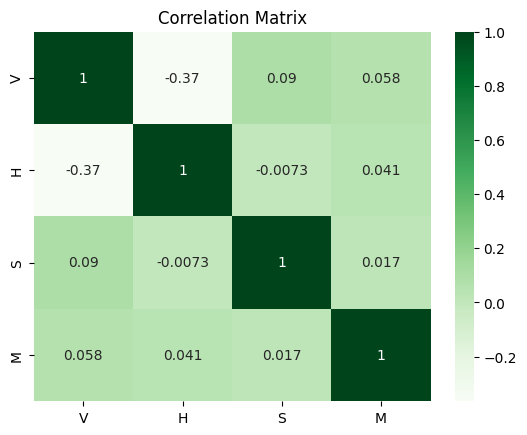

In [4]:
correlations = custom_df.corr('spearman')
sns.heatmap(correlations, annot=True, cmap='Greens')
plt.title('Correlation Matrix')
plt.show()

## Clustering

Since the input features are on different scales, scaling is necessary for the distance-based algorithms to work correctly. We'll use `StandardScaler` to scale our features to have a mean of 0 and a standard deviation of 1.

In [5]:
# Separate features and target, and scale the features
X, y = custom_df[['V','H','S']],custom_df['M']
scaler = StandardScaler()
X_scaled  = scaler.fit_transform(X)

### Hyperparameter Optimization

Now, let's find the best hyperparameters for our clustering models. We'll use `GridSearchCV` with the **silhouette score** to evaluate performance. The silhouette score measures how similar a data point is to its own cluster compared to other clusters. Scores range from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

In [6]:
from sklearn.model_selection import GridSearchCV

# Define a silhouette scorer for GridSearchCV
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    # Silhouette score is only defined if there is more than one cluster
    if len(set(labels)) > 1:
        return silhouette_score(X, labels)
    else:
        return -1 # Return a poor score if only one cluster is found

# Initialize the clustering models
cluster_models = {
    'KMeans': KMeans(n_init=10, random_state=0),
    'Agglomerative': AgglomerativeClustering(),
    'DBSCAN': DBSCAN()
}

# Define the hyperparameter grids for each model
param_grids = {
    'KMeans': {'n_clusters': range(3, 10)},
    'Agglomerative': {
        'n_clusters': range(3, 10),
        'linkage': ['ward', 'average', 'complete', 'single']
    },
    'DBSCAN': {
        'eps': np.arange(0.1, 1.1, 0.1), # Epsilon values from 0.1 to 1.0
        'min_samples': range(3, 30)
    }
}

optimized_models = {}

# Perform GridSearchCV to find the best models
for name, model in cluster_models.items():
    print('---- Optimising', name, '----')
    param_grid = param_grids[name]
    grid_search = GridSearchCV(model, param_grid, scoring=silhouette_scorer, cv=2)
    grid_search.fit(X_scaled)
    optimized_models[name] = grid_search.best_estimator_

    print('Best parameters for', name, ':', grid_search.best_params_)
    print('Best silhouette score for', name, ':', grid_search.best_score_)

---- Optimising KMeans ----


Exception in thread Thread-4 (_readerthread):
Traceback (most recent call last):
  File "c:\Program Files\Python313\Lib\threading.py", line 1043, in _bootstrap_inner
    self.run()
    ~~~~~~~~^^
  File "C:\Users\maxko\AppData\Roaming\Python\Python313\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
    ~~~~~~~~~~~~~~~~~~~~~^^^^^^
  File "c:\Program Files\Python313\Lib\threading.py", line 994, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Program Files\Python313\Lib\subprocess.py", line 1615, in _readerthread
    buffer.append(fh.read())
                  ~~~~~~~^^
  File "c:\Program Files\Python313\Lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 132: character maps to <undefi

Best parameters for KMeans : {'n_clusters': 5}
Best silhouette score for KMeans : 0.34904543512132225
---- Optimising Agglomerative ----
Best parameters for Agglomerative : {'linkage': 'average', 'n_clusters': 7}
Best silhouette score for Agglomerative : 0.31636353399689765
---- Optimising DBSCAN ----
Best parameters for DBSCAN : {'eps': np.float64(1.0), 'min_samples': 11}
Best silhouette score for DBSCAN : 0.39304435854581427


### Visualizing the Clusters

Since we only have three input features, we can use 3D plots to visualize the clusters, which is more interpretable than reducing dimensions with PCA.

Here's the visualization for the **KMeans** model. We compare the clusters found by the algorithm to the true labels from the dataset.

----- KMeans -----
Points per cluster: Counter({np.int32(2): 84, np.int32(0): 82, np.int32(4): 67, np.int32(1): 66, np.int32(3): 39})
True points per cluster: Counter({0: 71, 1: 70, 2: 66, 3: 66, 4: 65})
Silhouette: 0.3521691479861419


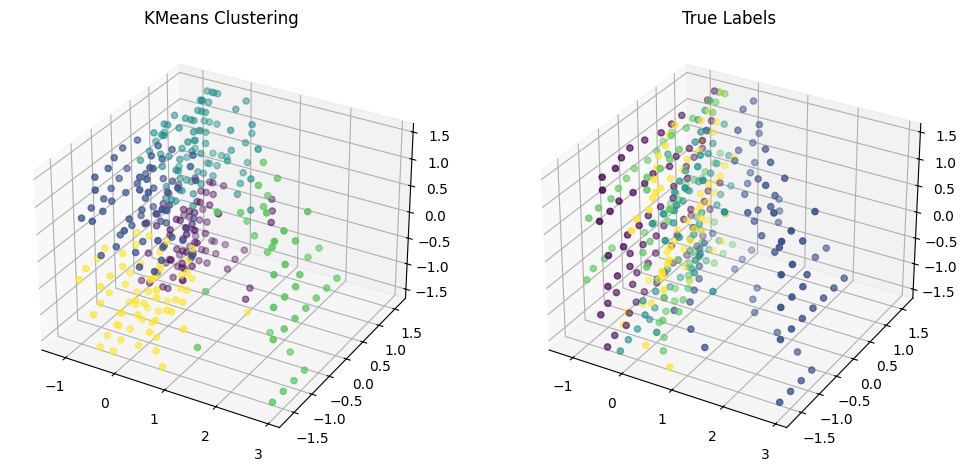

In [7]:
# Visualize the KMeans clusters
print("----- KMeans -----")
kmeans_model = optimized_models['KMeans']
kmeans_labels = kmeans_model.fit_predict(X_scaled)

# Print the number of points in each found cluster
print("Points per cluster:", Counter(kmeans_labels))
# Print the number of points in each true class
print("True points per cluster:", Counter(y))
# Print the silhouette score for the final model
print("Silhouette:", silhouette_score(X_scaled, kmeans_labels))

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], c=kmeans_labels, cmap='viridis')
ax1.set_title('KMeans Clustering')
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], c=y, cmap='viridis')
ax2.set_title('True Labels')
plt.show()

Now, for the **Agglomerative Clustering** model. This hierarchical approach gives us a different perspective on the data's structure.

----- Agglomerative -----
Points per cluster: Counter({np.int64(3): 84, np.int64(0): 80, np.int64(4): 69, np.int64(2): 65, np.int64(6): 20, np.int64(1): 14, np.int64(5): 6})
True points per cluster: Counter({0: 71, 1: 70, 2: 66, 3: 66, 4: 65})
Silhouette: 0.3229392541236912


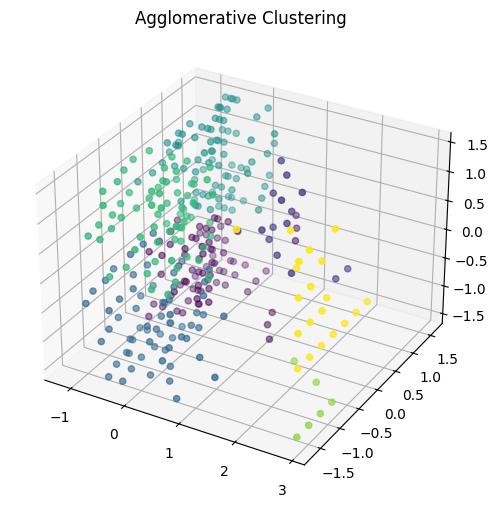

In [8]:
# Visualize the Agglomerative Clustering clusters
print("----- Agglomerative -----")
agg_model = optimized_models['Agglomerative']
agg_labels = agg_model.fit_predict(X_scaled)

print("Points per cluster:", Counter(agg_labels))
print("True points per cluster:", Counter(y))
print("Silhouette:", silhouette_score(X_scaled, agg_labels))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], c=agg_labels, cmap='viridis')
ax.set_title('Agglomerative Clustering')
plt.show()

And finally, for the **DBSCAN** model. Notice how DBSCAN identifies some points as noise (often labeled as -1).

----- DBSCAN -----
Points per cluster: Counter({np.int64(0): 309, np.int64(1): 18, np.int64(-1): 11})
True points per cluster: Counter({0: 71, 1: 70, 2: 66, 3: 66, 4: 65})
Silhouette: 0.3691356680692487


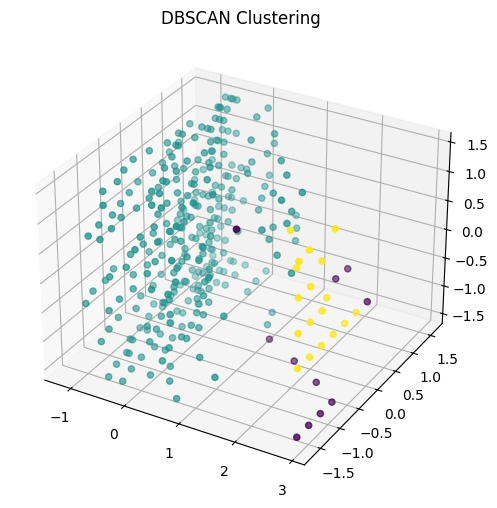

In [9]:
# Visualize the DBSCAN clusters
print("----- DBSCAN -----")
dbscan_model = optimized_models['DBSCAN']
dbscan_labels = dbscan_model.fit_predict(X_scaled)

print("Points per cluster:", Counter(dbscan_labels))
print("True points per cluster:", Counter(y))
# Only calculate silhouette score if more than one cluster was found
if len(set(dbscan_labels)) > 1:
    print("Silhouette:", silhouette_score(X_scaled, dbscan_labels))
else:
    print("Only one cluster found, cannot calculate silhouette score.")


fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], c=dbscan_labels, cmap='viridis')
ax.set_title('DBSCAN Clustering')
plt.show()

## Applications of Clustering Techniques

Clustering algorithms are incredibly versatile and have numerous real-world applications across various domains:

  * **Marketing**: Segmenting customers based on purchasing behavior for targeted advertising campaigns.
  * **Biology**: Grouping genes with similar expression patterns to understand genetic functions.
  * **Image Processing**: Using image segmentation to identify and separate objects within an image.
  * **Anomaly Detection**: Identifying fraudulent credit card transactions or network intrusions by flagging them as outliers.
  * **Urban Planning**: Grouping areas with similar traffic patterns or land use to optimize city resources.

## Conclusion

In this tutorial, we've explored the theory and practical application of three different clustering algorithms. We've seen how to preprocess data, optimize hyperparameters using `GridSearchCV`, and visualize the results in 3D. Each algorithm has its strengths and weaknesses, and the best choice always depends on the specific problem, the shape of the data, and the goals of the analysis.

I hope this tutorial has been a helpful step in your data science journey.